In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import seaborn as sns

In [2]:
spark = SparkSession.builder \
    .appName("Analyse de livres par genre") \
    .getOrCreate()

df = spark.read.csv("static/data/book_data.csv", header=True)

In [15]:
colors = ['#F5B7B1', '#AF7AC1', '#85C1E9', '#F5D3B3']

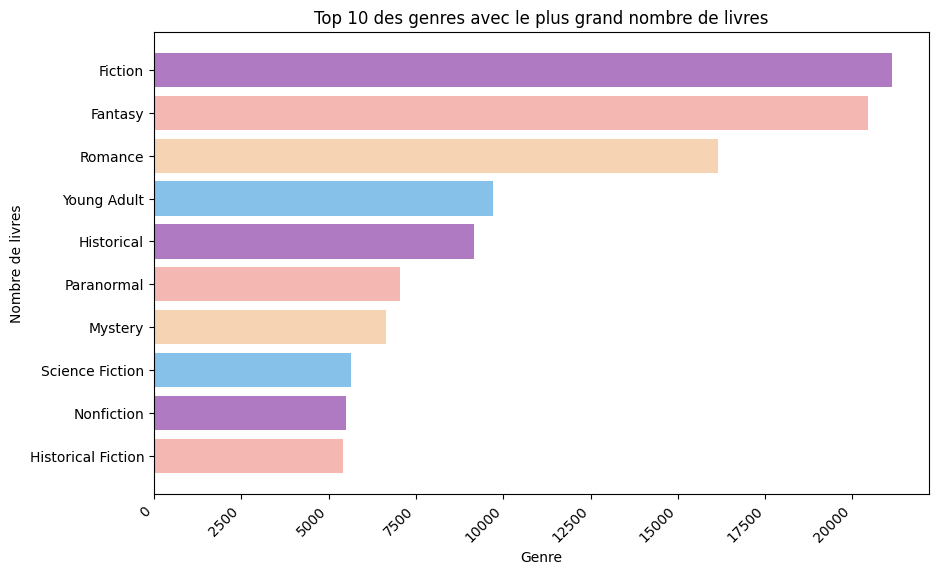

In [47]:

df.createOrReplaceTempView("livres")

df_cleaned = df.filter(df['genres'].like('%|%'))

genres_distincts = df_cleaned.select(explode(split(df_cleaned['genres'], '\|')).alias('genre')).distinct()

resultats = df_cleaned.select(explode(split(df_cleaned['genres'], '\|')).alias('genre')) \
                       .join(genres_distincts, 'genre') \
                       .groupBy('genre') \
                       .agg(count('*').alias('nb_livres')) \
                       .orderBy('genre')

resultats_tries = resultats.orderBy(resultats['nb_livres'].desc()).limit(10)

resultats_liste = resultats_tries.collect()

genres = [row['genre'] for row in resultats_liste[::-1]]
nb_livres = [row['nb_livres'] for row in resultats_liste[::-1]]

plt.figure(figsize=(10, 6),facecolor='none')
plt.barh(genres, nb_livres, color = colors)
plt.xlabel('Genre')
plt.ylabel('Nombre de livres')
plt.title('Top 10 des genres avec le plus grand nombre de livres')
plt.xticks(rotation=45, ha='right')
plt.gca().patch.set_facecolor('none')

plt.show()


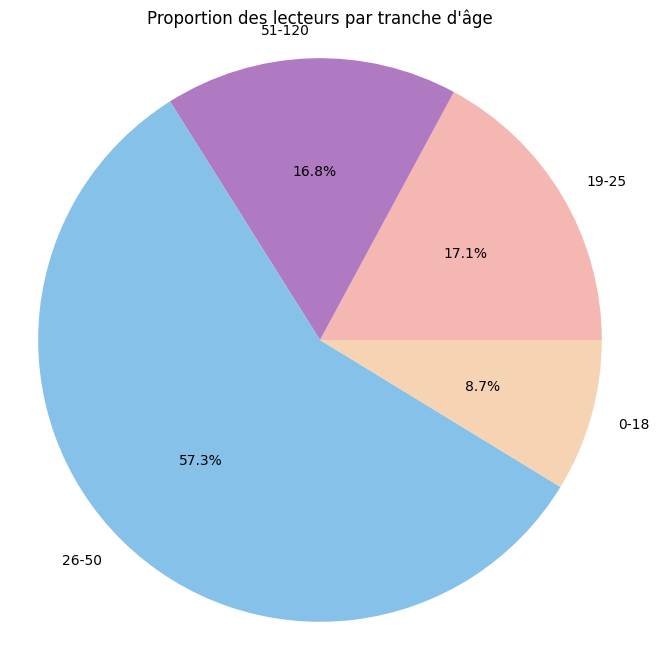

In [69]:
import matplotlib.pyplot as plt
df_book_2 = spark.read.csv("static/data/book_data_2.csv", header=True)

df_book_2 = df_book_2.na.drop()

df_age_avg = df_book_2.groupBy("User-ID").agg(avg("Age").alias("avg_age"))

df_with_age_groups = df_age_avg.withColumn(
    "age_group",
    when(col("avg_age") <= 18, "0-18")
    .when((col("avg_age") > 18) & (col("avg_age") <= 25), "19-25")
    .when((col("avg_age") > 25) & (col("avg_age") <= 50), "26-50")
    .otherwise("51-120")
)
age_group_counts = df_with_age_groups.groupBy('age_group').count()
total_users = df_with_age_groups.count()
age_group_percentage = age_group_counts.withColumn('percentage', (age_group_counts['count'] / total_users) * 100)

age_group_percentage_pandas = age_group_percentage.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(age_group_percentage_pandas['percentage'], labels=age_group_percentage_pandas['age_group'], autopct='%.1f%%', colors=colors)
plt.axis('equal')
plt.title('Proportion des lecteurs par tranche d\'âge')

plt.gca().patch.set_facecolor('none')
plt.show()

In [88]:

df_users = pd.read_excel('static/data/01_user.xlsx', sheet_name='Result 1')
df_users_book = pd.read_excel('static/data/04_user_book.xlsx', sheet_name='Result 1')
df_books_3 = pd.read_excel('static/data/05_book.xlsx', sheet_name='Result 1')

merged_df = pd.merge(df_users_book, df_books_3, left_on='book_id', right_on='id')
merged_df = pd.merge(df_users, merged_df, on='user_id')
male_books = merged_df[merged_df['gender'] == 'M']

genres_series = male_books['gender'].str.split('|', expand=True).stack()

genre_counts = genres_series.value_counts().reset_index()
genre_counts.columns = ['gender', 'gender_count']

top_20_genres = genre_counts.head(20)

print(top_20_genres)

          user_id  birth_year gender                     created_at    직업  \
0           10936      1986.0      M         2019-07-20 11:16:15+00   직장인   
1           10936      1986.0      M         2019-07-20 11:16:15+00   직장인   
2           10936      1986.0      M         2019-07-20 11:16:15+00   직장인   
3           10936      1986.0      M         2019-07-20 11:16:15+00   직장인   
4           10936      1986.0      M         2019-07-20 11:16:15+00   직장인   
...           ...         ...    ...                            ...   ...   
563047  555758878      1990.0      F  2022-04-13 02:03:19.642164+00  프리랜서   
563048  555758878      1990.0      F  2022-04-13 02:03:19.642164+00  프리랜서   
563049  555758878      1990.0      F  2022-04-13 02:03:19.642164+00  프리랜서   
563050  555758878      1990.0      F  2022-04-13 02:03:19.642164+00  프리랜서   
563051  555758878      1990.0      F  2022-04-13 02:03:19.642164+00  프리랜서   

         직종  book_id  rate         read_status                 modified_at 

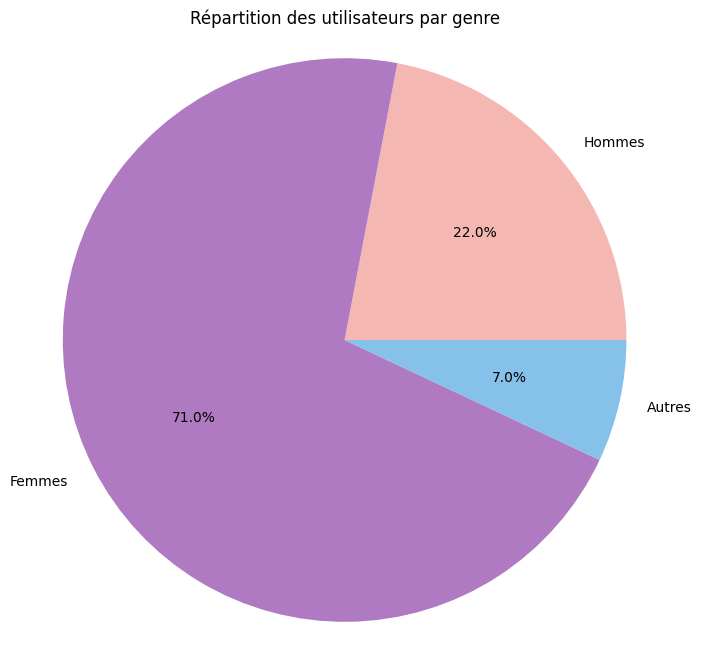

In [110]:
merged_data = pd.merge(df_users_book, df_users, on='user_id', how='inner')

user_counts = merged_data['user_id'].value_counts().reset_index()
user_counts.columns = ['user_id', 'count']

total_users = len(user_counts)

male_users = merged_data[merged_data['gender'] == 'M']['user_id'].nunique()
female_users = merged_data[merged_data['gender'] == 'F']['user_id'].nunique()
other_users = merged_data[~merged_data['gender'].isin(['M', 'F'])]['user_id'].nunique()

male_proportion =  np.round(male_users / total_users, 2)
female_proportion =  np.round(female_users / total_users, 2)
other_users_proportion =  np.round(other_users / total_users, 2)

labels = ['Hommes', 'Femmes', 'Autres']
sizes = [male_proportion, female_proportion, other_users_proportion]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.title('Répartition des utilisateurs par genre')
plt.axis('equal')
plt.gca().patch.set_facecolor('none')

plt.show()

C:\Users\Quentin\AppData\Local\Temp\ipykernel_19552\3753703976.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_books_complete, x="Rating", kde=True, palette=colors)


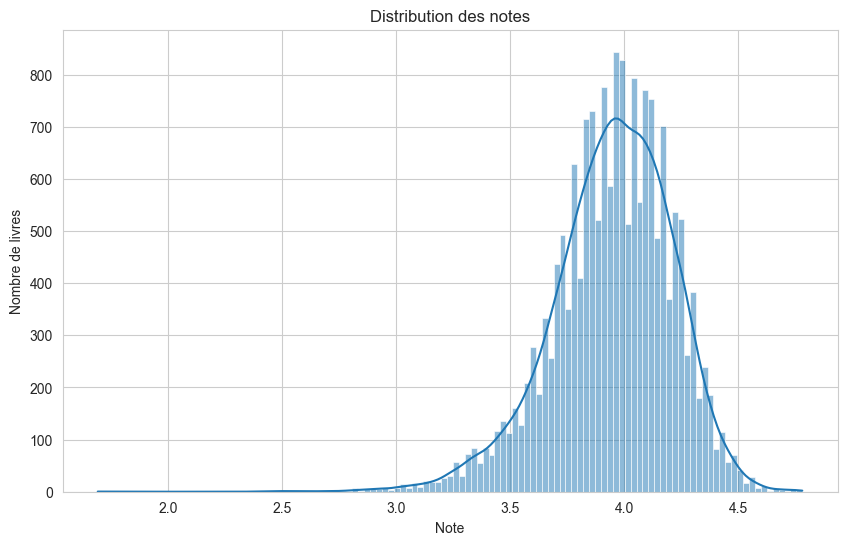

In [17]:
df_books_complete = pd.read_csv('static/data/book_data_3.csv')
df_books_complete = df_books_complete[df_books_complete['CountsOfReview'] >= 100]

sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sns.histplot(df_books_complete, x="Rating", kde=True, palette=colors)
plt.title('Distribution des notes')
plt.xlabel('Note')
plt.ylabel('Nombre de livres')
plt.show()